In [3]:
import pygmt
pygmt.makecpt(cmap="polar+h0",background=True,transparency=0,series=[-5,5,0.5],output='/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/PaperIIPlots/PaperI/r2/error.cpt')
                

Compare Depths

BS_manning003/E01267N3753E01646N3535-BS-M809_E01502N3737_D010_S112D70R270_A006995_S075 
 36745


/tmp/ipykernel_978850/4194691361.py:202: RuntimeWarning: invalid value encountered in cast
  fill2 = fill2.astype(int)
xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values


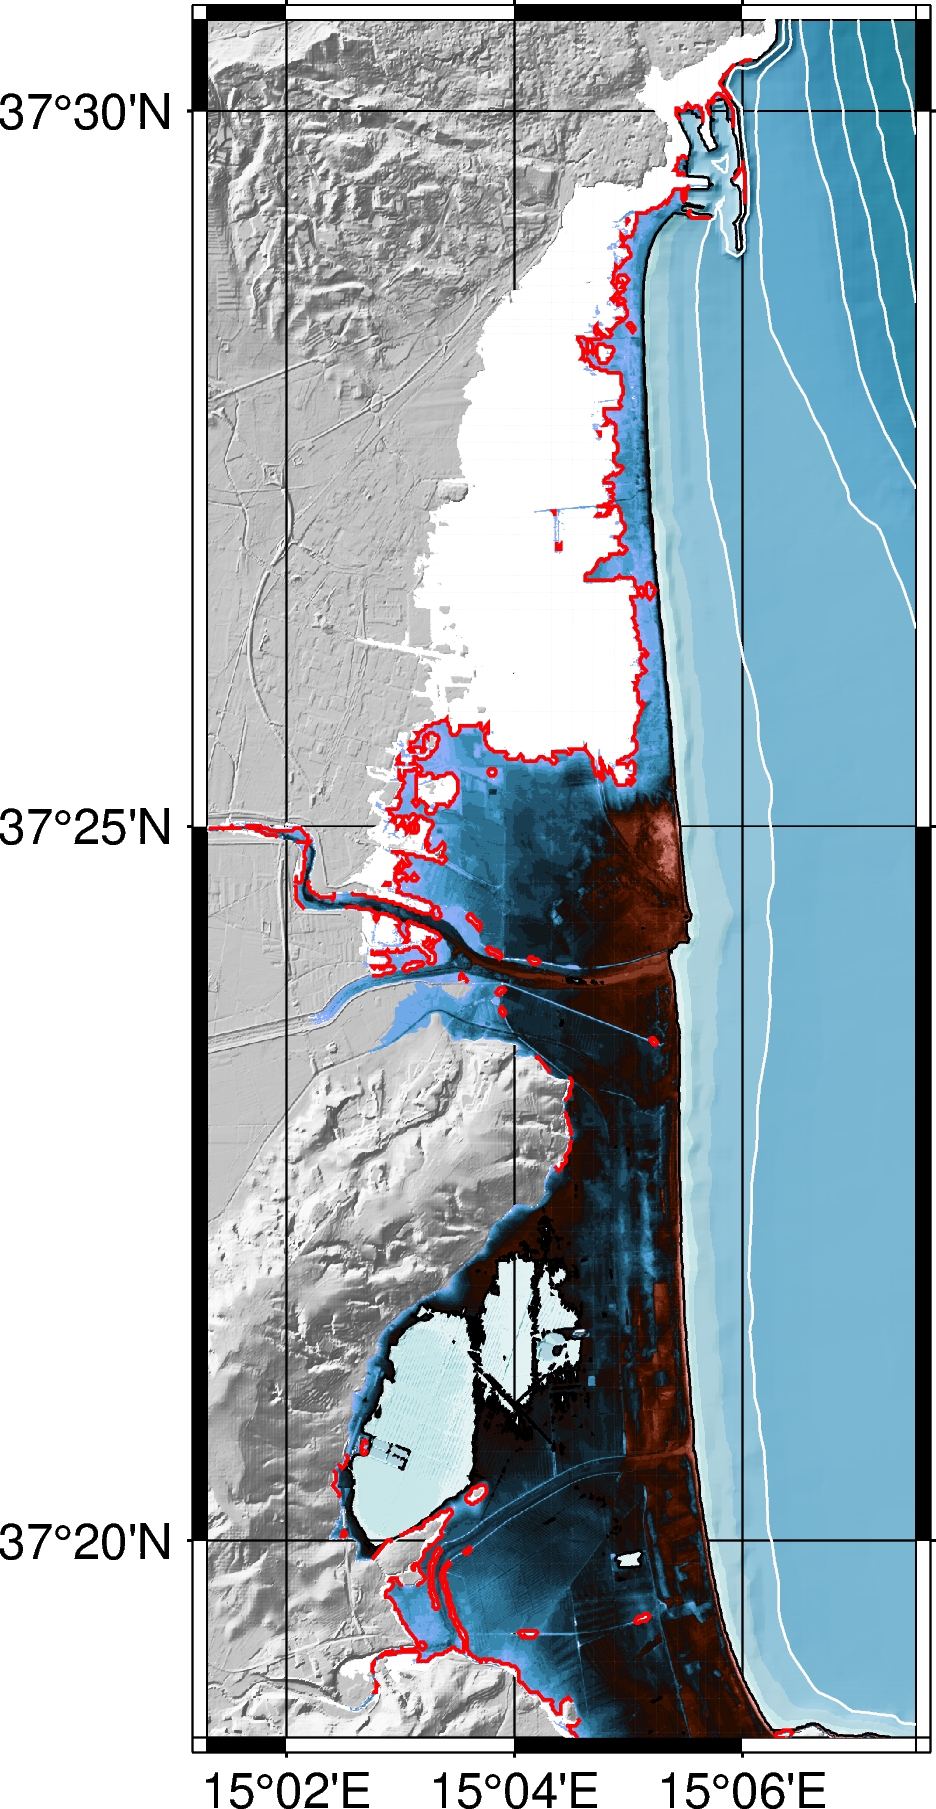

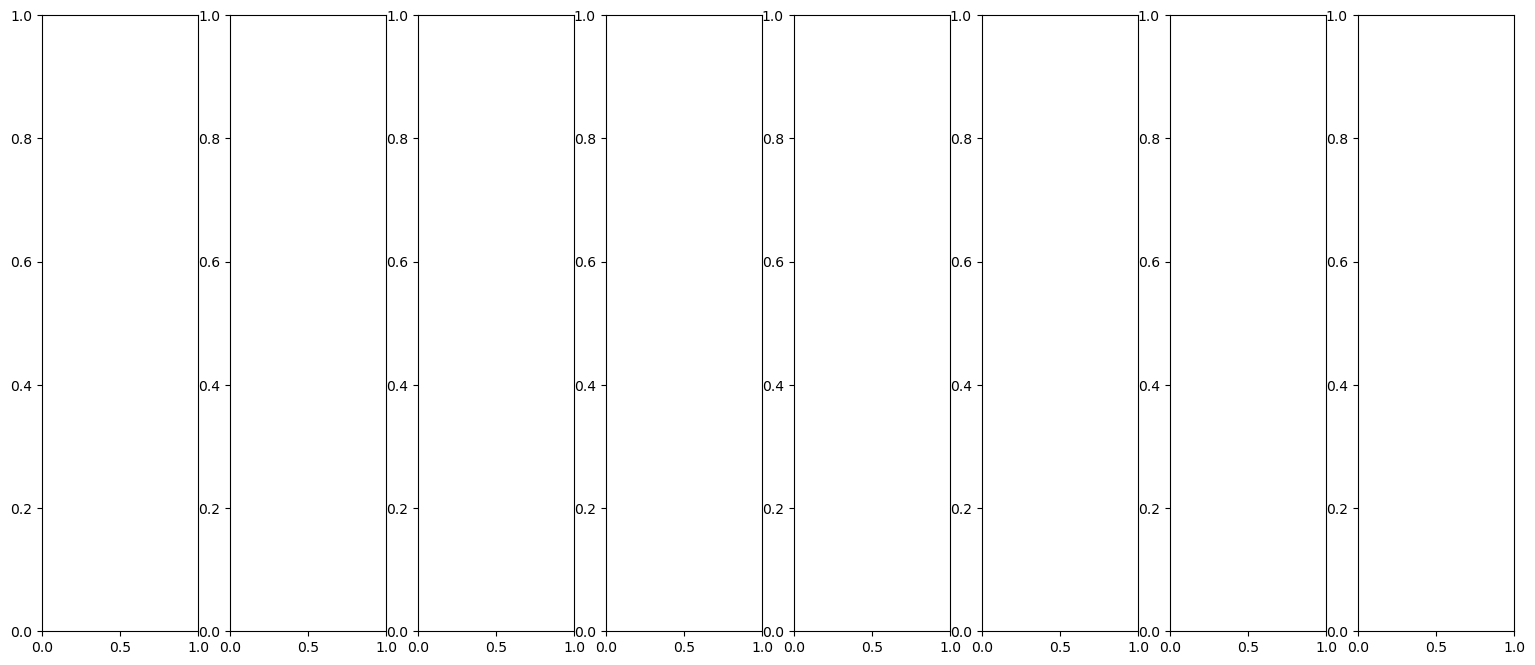

In [5]:
#Description: Plot depth predictions and errors for different models for a given event
import os
import sys
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pygmt

try:
    MLDir = os.getenv('MLDir')
    SimDir = os.getenv('SimDir')
    reg = 'CT'
    mode = 'compare'
    train_size = '1658'
    mask_size = '892'
    # reg = sys.argv[1] #CT or SR
    # mode = sys.argv[2] #reprocess or post
    # train_size = sys.argv[3] #eventset size used for training
    # mask_size = sys.argv[4] #eventset size used for testing
except:
    raise Exception("*** Must first set environment variable")

#set seed
np.random.seed(0)

def calculate_error(true, pred):
        # Set NaN for rows where count_test is less than 1
        error1 = true - pred
        error2 = pred - true
        error = np.where(np.abs(error1) < np.abs(error2), error1, -error2)
        error = np.where((error < 0.1) & (error > -0.1), 0, error)
        return error

#dimensions and gauge numbers
if reg == 'SR':
    GaugeNo = list(range(53,58)) #rough pick for Siracusa
    columnname = str(54)
    x_dim = 1300  #lon
    y_dim = 948 #lat
    ts_dim = len(GaugeNo) #gauges time series
    pts_dim = 480 #time steps
    list_size = ['961','1773','3669','6941']
    control_points = [[37.01,15.29],
        [37.06757,15.28709],
        [37.05266,15.26536],
        [37.03211,15.28632]]   
    
elif reg == 'CT':
    GaugeNo = list(range(35,44)) #for Catania
    columnname = str(38)
    x_dim = 912
    y_dim = 2224
    ts_dim = len(GaugeNo)
    pts_dim = 480
    list_size = ['892','1658','3454','7071'] 
    control_points =  [[37.5022,15.0960],
        [37.48876,15.08936],
        [37.47193,15.07816],
        [37.46273,15.08527],
        [37.46252,15.08587],
        [37.45312,15.07874],
        [37.42821,15.08506],
        [37.40958,15.08075],
        [37.38595,15.08539],
        [37.35084,15.08575],
        [37.33049,15.07029],
        [37.40675,15.05037]]

if mode == 'compare':
    #check if PTHA directory exists
    if not os.path.exists(f'{MLDir}/model/{reg}/compare'):
        os.makedirs(f'{MLDir}/model/{reg}/compare')

    #predictions and post processed predictions
    # true_depths = np.load(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/PTHA/true_d_53550.npy')
    # pred_depths_nodeform = np.load(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/PTHA/pred_d_{train_size}_nodeform.npy')
    # eve_perf_nodeform = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')
    # # pred_depths_direct = np.load(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/PTHA/pred_d_{train_size}_direct.npy')
    # eve_perf_direct = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/model_direct_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')            
    # pred_depths_pretrain = np.load(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/PTHA/pred_d_{train_size}.npy')
    # eve_perf_pretrain = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/model_coupled_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')            
    eve_id = np.loadtxt('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/sample_events53550.txt',dtype='str')   
    #inundation attributes
    flood_mask = ~np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
    nflood_grids = np.count_nonzero(flood_mask)
    zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
    index_map = pd.read_csv(f'{MLDir}/data/processed/lat_lon_idx_{reg}_{mask_size}.txt',sep=',',header=None)
    index_map.columns = ['m','n','lat','lon'] #add column names

    #plotting the below events
    ids = [
        'BS_manning003/E01267N3753E01646N3535-BS-M809_E01502N3737_D010_S112D70R270_A006995_S075',
        # 'BS_manning003/E01267N3753E01646N3535-BS-M809_E01502N3737_D144_S022D70R270_A006995_S075',
        # 'PS_manning003/E02020N3739E02658N3366-PS-Str_PYes_Var-M902_E02417N3454_S001',
        # 'BS_manning003/E01267N3753E01646N3535-BS-M809_E01547N3670_D010_S337D70R270_A006995_S075',
        # 'BS_manning003/E01267N3753E01646N3535-BS-M809_E01495N3692_D010_S022D50R270_A006995_S075',
        # 'BS_4-8_manning003/E01267N3753E01646N3535-BS-M809_E01502N3737_D010_S067D90R090_A006995_S075',
        # 'BS_manning003/E01267N3753E01646N3535-BS-M809_E01523N3692_D010_S292D50R270_A006995_S075',
        # 'PS_manning003/E02020N3739E02658N3366-PS-Str_PYes_Var-M895_E02351N3465_S003',
        # 'BS_4-8_manning003/E01267N3753E01646N3535-BS-M809_E01551N3692_D010_S112D90R090_A006995_S075',
        ]
    
    for id in ids:
        eve = np.where(eve_id==id)[0][0]
        print(id,'\n',eve)
        # eve=32145
        # id =eve_id[eve]

        # #read dZ file and grid location file to extract location information
        # data2plot = xr.open_dataset(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/{id}/{reg}_deformation.nc')
        # dz = data2plot['deformation'].values
        # # (948 x 1300)
        # # x = data2plot['x'].values #1300
        # # y = data2plot['y'].values #948

        # x = np.linspace(0,dz.shape[1],dz.shape[1])
        # y = np.linspace(0,dz.shape[0],dz.shape[0])

        # #create list of x,y,dz
        # xy_mesh = np.meshgrid(x,y)
        # # dz_smooth = gaussian_filter(dz, sigma=50)
        # dz_smooth = dz
        # x_list,y_list = xy_mesh[0].flatten(),xy_mesh[1].flatten()
        # dz_list = dz.flatten()

        #cm to m
        # pred_pretrain=pred_depths_pretrain[eve]/100
        # pred_direct=pred_depths_direct[eve]/100
        # pred_nodeform=pred_depths_nodeform[eve]/100
        # true=true_depths[eve]/100
      
        #calculate errors
        # error_pretrain = calculate_error(true, pred_pretrain)
        # error_direct = calculate_error(true, pred_direct)
        # error_nodeform = calculate_error(true, pred_nodeform)

        #remove micro depths for better visualization
        # pred_pretrain= np.where(pred_pretrain < 0.1, np.nan, pred_pretrain)
        # pred_direct= np.where(pred_direct < 0.1, np.nan, pred_direct)
        # pred_nodeform= np.where(pred_nodeform < 0.1, np.nan, pred_nodeform)
        # true= np.where(true < 0.1, np.nan, true)
        
        #additional region specific parameters for plotting
        if reg == 'CT':
            fig, axs = plt.subplots(1, 8, figsize=(19,8))
            pos = "TL"
            cbar_ht = 0.02
            # Load the elevation from netcdf grid
            grid = xr.open_dataset('../../data/processed/CT_defbathy.nc',engine='netcdf4')

        elif reg == 'SR':
            fig, axs = plt.subplots(1, 8, figsize=(19,3))
            pos = "BL"
            cbar_ht = 0.04
            # Load the elevation from netcdf grid
            grid = xr.open_dataset('../../data/processed/SR_defbathy.nc',engine='netcdf4')
        
        #get lat long limits from the grid
        ymin = grid['y'].min().values
        ymax = grid['y'].max().values
        xmin = grid['x'].min().values
        xmax = grid['x'].max().values
        axs = axs.ravel()

        # Plot performance variable values
        cmap_depth = plt.get_cmap('twilight',20)
        cmap_error = plt.get_cmap('seismic', 10)
        cmap_dz = plt.get_cmap('RdYlGn_r',10)

        # depth_max = max(np.nanmax(pred),np.nanmax(true))
        # error_max = round(np.nanmax(np.abs(error)))
        # dz_max = round(np.nanmax(np.abs(dz_smooth)))

        #color maps
        cptfile_bathy = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/PaperIIPlots/PaperI/r2/bathy_error.cpt'      
        fig = pygmt.Figure()
        with fig.subplot(
                        nrows=1,
                        ncols=7,
                        subsize = ["7c","20c"],
                        sharey = True,
                        frame = ["ag"],
                        clearance  = "s3c",
            ):
            with fig.set_panel(panel=[0,0]): #true inundation depth
                #basemap
                cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
                fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c')
                fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
                #load
                # np.save(f'{MLDir}/model/{reg}/compare/true_{train_size}_{reg}_{str(eve)}_x.npy',index_map['lon'][filter])
                # np.save(f'{MLDir}/model/{reg}/compare/true_{train_size}_{reg}_{str(eve)}_y.npy',index_map['lat'][filter])
                # np.save(f'{MLDir}/model/{reg}/compare/true_{train_size}_{reg}_{str(eve)}_fill.npy',true[filter])
                x = np.load(f'{MLDir}/model/{reg}/compare/true_{train_size}_{reg}_{str(eve)}_x.npy')
                y = np.load(f'{MLDir}/model/{reg}/compare/true_{train_size}_{reg}_{str(eve)}_y.npy')
                fill = np.load(f'{MLDir}/model/{reg}/compare/true_{train_size}_{reg}_{str(eve)}_fill.npy')
                fill2 = fill * 100
                #make fill2 int
                fill2 = fill2.astype(int)

                #set values below 0.1 to 90 and above to 110 
                pygmt.makecpt(cmap="berlin", series=[0.1,10,0.5],transparency=0,reverse = False,background=True)      
                fig.plot(x=x, y=y,fill=fill,style='s0.01c',cmap = True,projection='M6c')
                fig.grdcontour(grid=grid['z'], levels=1,limit=[-0.5, 0.5],annotation=False,projection='M6c',pen='0.5p,black')
                grid_depth = pygmt.xyz2grd(x=x, y=y, z=fill2, spacing='1s', region=[xmin,xmax,ymin,ymax])
                #plot depth
                # fig.grdimage(grid_depth, cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c')
                fig.grdcontour(grid_depth, levels=[1], pen='0.75p,red', limit=[0,10],projection='M6c',cut=10)
                fig.show()
                #parameter     
                # pygmt.makecpt(cmap="red2green+h0", series=[-5,5,0.5], continuous=False)          
                # fig.plot(x=index_map['lon'], y=index_map['lat'],fill=5,style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
                # fig.colorbar(cmap=True, position="JBC+o0/1c+w10c/0.5c+h",frame=["a2","x+lDeformation", "y+lm"])
            # with fig.set_panel(panel=[0,0]): #true inundation depth
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c')
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     #parameter     
            #     pygmt.makecpt(cmap="berlin", series=[0.1,10,0.5],transparency=50,reverse = False)     
            #     filter = ~np.isnan(true)          
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=true[filter],style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
            #     fig.text(position = pos, text=f'max: {np.nanmax(true[filter]):.3f}',font="15p,Helvetica-Bold,black")
                # fig.colorbar(cmap=True, position="JBC+o0/1c+w10c/0.5c+h",frame=["a2","x+lDepth", "y+lm"])
            # with fig.set_panel(panel=[0,1]): #nodeform inundation depth
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c')
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     # parameter     
            #     pygmt.makecpt(cmap="berlin", series=[0.1,10,0.5],transparency=0,reverse = False)              
            #     filter = ~np.isnan(pred_nodeform) 
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=pred_nodeform[filter],style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
            # with fig.set_panel(panel=[0,2]): #nodeform inundation error
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c')
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     #parameter     
            #     pygmt.makecpt(cmap="polar+h0", transparency=0,series=[-5,5,0.5],background=True)
            #     filter = ~np.isnan(error_nodeform) 
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=error_nodeform[filter],style='s0.01c',cmap = True,projection='M6c')
                # fig.colorbar(cmap=True, position="JBC+o0/1c+w10c/0.5c+h",frame=["a2","x+lError", "y+lm"])
            # fig.savefig(f'./plots/DepthColorbar.png',dpi=300)
            # fig.savefig(f'./plots/ErrorColorbar.png',dpi=300)
            # fig.savefig(f'./plots/DeformColorbar.png',dpi=300)
            # fig.show()
            # with fig.set_panel(panel=[0,3]): #with deformation inundation depth
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c',frame = ["+tDeform"])
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     #parameter     
            #     pygmt.makecpt(cmap="berlin", series=[0.1,10,0.5],transparency=0,reverse = False)              
            #     filter = ~np.isnan(pred_direct) 
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=pred_direct[filter],style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
            # with fig.set_panel(panel=[0,4]): #with deformation inundation error
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c',frame = ["+tDeformError"])
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     #parameter     
            #     pygmt.makecpt(cmap="polar+h0", transparency=0,series=[-5,5,0.5])
            #     filter = ~np.isnan(error_direct) 
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=error_direct[filter],style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
            # with fig.set_panel(panel=[0,5]): #with deformation and pretrain inundation depth
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c',frame = ["+tDeformPretrain"])
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     #parameter     
            #     pygmt.makecpt(cmap="berlin", series=[0.1,10,0.5],transparency=0,reverse = False)              
            #     filter = ~np.isnan(pred_pretrain) 
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=pred_pretrain[filter],style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
            # with fig.set_panel(panel=[0,6]): #with deformation and pretrain inundation error
            #     #basemap
            #     cmap = pygmt.makecpt(cmap=cptfile_bathy,continuous=False)
            #     fig.grdimage(grid['z'], cmap=True, shading=True,region=[xmin,xmax,ymin,ymax],projection='M6c',frame = ["+tDeformPretrainError"])
            #     fig.grdcontour(grid['z'], levels=10, pen='0.5p,white', limit=[-100, 0],projection='M6c')
            #     #parameter     
            #     pygmt.makecpt(cmap="polar+h0", transparency=0,series=[-5,5,0.5])
            #     filter = ~np.isnan(error_pretrain) 
            #     fig.plot(x=index_map['lon'][filter], y=index_map['lat'][filter],fill=error_pretrain[filter],style='s0.01c',cmap = True,projection='M6c',frame = ["ag"])
    

In [11]:
np.max(grid_depth)

<xarray.DataArray 'z' ()> Size: 8B
array(1160.33337402)